In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf

In [2]:
datawc109 = pd.read_csv("")
datawc105 = pd.read_csv("")
datawc110 = pd.read_csv("")
datawc111 = pd.read_csv("")
datawc112 = pd.read_csv("")

In [3]:
def data_prep(data):
    columns = list(data.columns)
    columns.remove('ParameterCreatedDate')
    columns.remove('RUL')

    data["ParameterCreatedDate"] = pd.to_datetime(data["ParameterCreatedDate"])
    data["ParameterCreatedDate"] = (data['ParameterCreatedDate'] - data['ParameterCreatedDate'].min()) / (data['ParameterCreatedDate'].max() - data['ParameterCreatedDate'].min())
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    target_scaler = MinMaxScaler()
    data["RUL"] = target_scaler.fit_transform(data["RUL"].values.reshape(-1, 1))

    print("Checking for NaN or infinite values in data:")
    print(np.any(np.isnan(data)))
    print(np.any(np.isinf(data)))
    print("Data shape:", data.shape)

    nan_columns = data.columns[data.isna().any()].tolist()
    print("Columns with NaN values:", nan_columns)

    print("Number of NaN values in each column:")
    print(data[nan_columns].isna().sum())

    data_cleaned = data.fillna(data.mean())

    print("Checking for NaN values after cleaning:")
    print(np.any(np.isnan(data_cleaned)))

    data = data_cleaned

    return data

In [4]:
def create_model(input_shape, gru_units=64):
    model = Sequential([
        Bidirectional(GRU(units=gru_units, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.1),
        GRU(units=int(gru_units/2), return_sequences=True), 
        BatchNormalization(),
        Dropout(0.1),
        GRU(units=int(gru_units/2)), 
        BatchNormalization(),
        Dropout(0.05),
        Dense(gru_units),
        Dense(units=1, kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.1))
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [5]:
def plot_training_history(history, test_loss=None):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    if test_loss is not None:
        plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

In [6]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual RUL')
    plt.plot(y_pred, label='Predicted RUL')
    plt.title('Actual vs Predicted RUL')
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def plot_cv_results(results):
    mse = [result['loss'] for result in results]
    mae = [result['mae'] for result in results]
    print("cv - mse:", mse)
    print("cv - mae:", mae)
    

    plt.figure(figsize=(10, 5))
    plt.plot(mse, marker='o', label='MSE')
    plt.plot(mae, marker='o', label='MAE')
    plt.title('Cross-Validation Results')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def cv_gru(data, labels, n_splits=5, sequence_length=1500, batch_size=32, epochs=150):
    input_columns = [col for col in data.columns if col not in ['RUL', 'ParameterCreatedDate']]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1
    
    for fold, (train_index, test_index) in enumerate(tscv.split(data)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
    
        train_data, test_data = data.iloc[train_index], data.iloc[test_index]
        train_labels, test_labels = labels[train_index].values, labels[test_index].values
    
        split_index = int(len(train_data) * train_ratio)  # 80% for training
        val_split_index = int(len(train_data) * (train_ratio + val_ratio))  # 10% for validation (90% of train_data)
    
        val_data = train_data.iloc[split_index:val_split_index]
        train_data = train_data.iloc[:split_index]
        val_labels = train_labels[split_index:val_split_index]
        train_labels = train_labels[:split_index]
    
        train_sequence_gen = TimeseriesGenerator(data=train_data[input_columns].values,
                                                 targets=train_labels,
                                                 length=sequence_length, batch_size=batch_size)
    
        val_sequence_gen = TimeseriesGenerator(data=val_data[input_columns].values,
                                               targets=val_labels,
                                               length=sequence_length, batch_size=batch_size)
    
        test_sequence_gen = TimeseriesGenerator(data=test_data[input_columns].values,
                                                targets=test_labels,
                                                length=sequence_length, batch_size=batch_size)
    
    
        x_train, y_train = train_sequence_gen[0]
        x_val, y_val = val_sequence_gen[0]
        x_test, y_test = test_sequence_gen[0]

        model = create_model(input_shape=(x_train.shape[1], x_train.shape[2]), gru_units=128)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
        early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(x_val, y_val),  
                            callbacks=[reduce_lr, early_stopping], verbose=1)



        loss, mae = model.evaluate(x_test, y_test)

        results.append({'loss': loss, 'mae': mae})

        plot_training_history(history, loss)
        
        print(f"Fold {fold + 1} results: Test Loss(mse): {loss}, Test MAE: {mae}")

    losses = [result['loss'] for result in results]
    maes = [result['mae'] for result in results]

    
    print(f"Average Loss: {np.mean(losses)} ± {np.std(losses)}")
    print(f"Average MAE: {np.mean(maes)} ± {np.std(maes)}")

    
    return results

In [9]:
datawc109 = data_prep(datawc109)
datawc105 = data_prep(datawc105)
datawc110 = data_prep(datawc110)
datawc111 = data_prep(datawc111)
datawc112 = data_prep(datawc112)


Checking for NaN or infinite values in data:
True
False
Data shape: (871018, 55)
Columns with NaN values: ['Back Pressure', 'Barrel Temp. Zone 1', 'Barrel Temp. Zone 2', 'Barrel Temp. Zone 3', 'Barrel Temp. Zone 4', 'Closed Shutter injection nozzle first step', 'Closed Shutter injection nozzle second step', 'Cooling Time', 'Cushion', 'Cycle Time', 'Decompression after stroke', 'Decompression before stroke', 'Dosage Stroke', 'Injection Pressure Actual', 'Injection Pressure Max.', 'Injection Speed 1', 'Injection Speed 10', 'Injection Speed 2', 'Injection Speed 3', 'Injection Speed 4', 'Injection Speed 5', 'Injection Speed 6', 'Injection Speed 7', 'Injection Speed 8', 'Injection Speed 9', 'Injection Time', 'Mould Temp. Cav 1', 'Mould Temp. Cav 10', 'Mould Temp. Cav 11', 'Mould Temp. Cav 12', 'Mould Temp. Cav 2', 'Mould Temp. Cav 3', 'Mould Temp. Cav 4', 'Mould Temp. Cav 5', 'Mould Temp. Cav 6', 'Mould Temp. Cav 7', 'Mould Temp. Cav 8', 'Mould Temp. Cav 9', 'Open Shutter injection nozzle f

MODAL FOR WORK CENTER 109 

Processing fold 1/5...
Epoch 1/150
1/1 [==============================] - 12s 12s/step - loss: 2.2325 - mae: 0.5816 - val_loss: 1.5708 - val_mae: 0.1357 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 472ms/step - loss: 2.3382 - mae: 0.6890 - val_loss: 1.5662 - val_mae: 0.1434 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 390ms/step - loss: 2.1705 - mae: 0.6711 - val_loss: 1.5645 - val_mae: 0.1589 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 379ms/step - loss: 1.9164 - mae: 0.5307 - val_loss: 1.5570 - val_mae: 0.1565 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 383ms/step - loss: 1.8873 - mae: 0.4650 - val_loss: 1.5460 - val_mae: 0.1426 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 386ms/step - loss: 1.8472 - mae: 0.4840 - val_loss: 1.5338 - val_mae: 0.1238 - lr: 0.0010
Epoch 7/150
1/1 [==============================] - 0s 379ms/step - loss: 1.7486 - mae: 0.3948 - val_loss: 1.5226 -

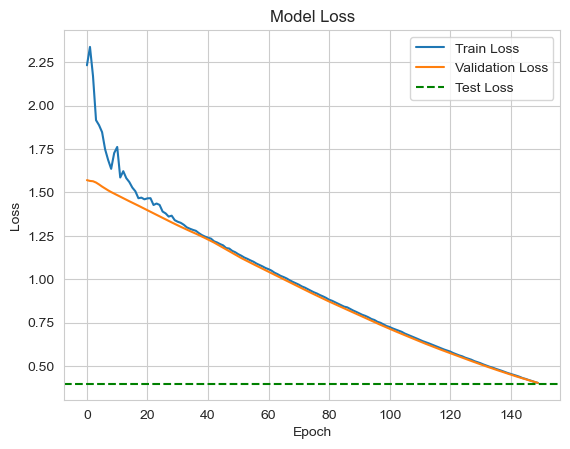

Fold 1 results: Test Loss(mse): 0.39749857783317566, Test MAE: 0.055335961282253265
Processing fold 2/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.9181 - mae: 0.8854 - val_loss: 1.6147 - val_mae: 0.2764 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 392ms/step - loss: 2.9043 - mae: 0.9846 - val_loss: 1.6108 - val_mae: 0.2814 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 382ms/step - loss: 2.3072 - mae: 0.7041 - val_loss: 1.5982 - val_mae: 0.2707 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 385ms/step - loss: 2.1096 - mae: 0.5508 - val_loss: 1.5900 - val_mae: 0.2675 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 384ms/step - loss: 1.9892 - mae: 0.5412 - val_loss: 1.5779 - val_mae: 0.2569 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 378ms/step - loss: 1.9193 - mae: 0.5107 - val_loss: 1.5654 - val_mae: 0.2452 - lr: 0.0010
Epoch 7/150
1/1 [===============

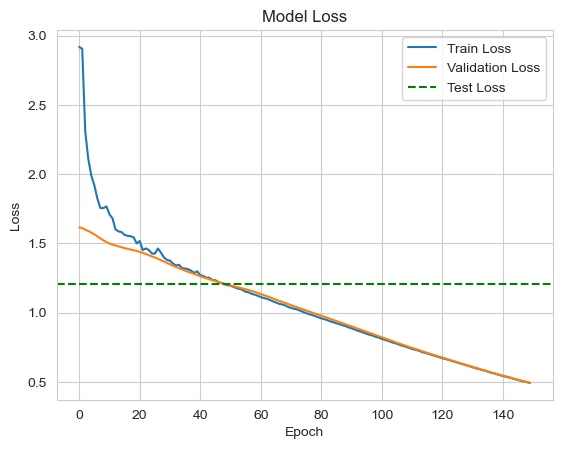

Fold 2 results: Test Loss(mse): 1.2090325355529785, Test MAE: 0.852307915687561
Processing fold 3/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.4653 - mae: 1.0427 - val_loss: 2.0715 - val_mae: 0.5612 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 386ms/step - loss: 3.1783 - mae: 0.8098 - val_loss: 2.0964 - val_mae: 0.5883 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 371ms/step - loss: 2.6837 - mae: 0.7913 - val_loss: 2.1073 - val_mae: 0.6027 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 376ms/step - loss: 2.1866 - mae: 0.5541 - val_loss: 2.0995 - val_mae: 0.6014 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 372ms/step - loss: 2.2599 - mae: 0.6042 - val_loss: 2.0922 - val_mae: 0.5964 - lr: 2.0000e-04
Epoch 6/150
1/1 [==============================] - 0s 375ms/step - loss: 2.4878 - mae: 0.6589 - val_loss: 2.0829 - val_mae: 0.5896 - lr: 2.0000e-04
Epoch 7/150
1/1 [===========

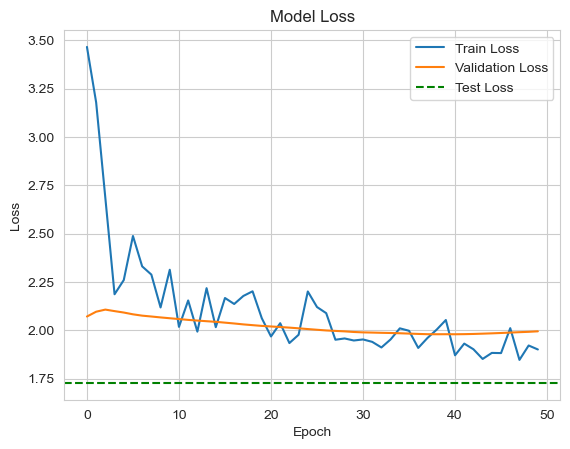

Fold 3 results: Test Loss(mse): 1.728261947631836, Test MAE: 0.13460113108158112
Processing fold 4/5...
Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 1.9469 - mae: 0.5248 - val_loss: 1.5166 - val_mae: 0.1985 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 393ms/step - loss: 2.6863 - mae: 0.8620 - val_loss: 1.5028 - val_mae: 0.1802 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 390ms/step - loss: 1.7777 - mae: 0.4465 - val_loss: 1.4870 - val_mae: 0.1534 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 379ms/step - loss: 1.8400 - mae: 0.5193 - val_loss: 1.4748 - val_mae: 0.1354 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 390ms/step - loss: 1.7640 - mae: 0.4336 - val_loss: 1.4632 - val_mae: 0.1184 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 384ms/step - loss: 1.8023 - mae: 0.4797 - val_loss: 1.4521 - val_mae: 0.1028 - lr: 0.0010
Epoch 7/150
1/1 [==================

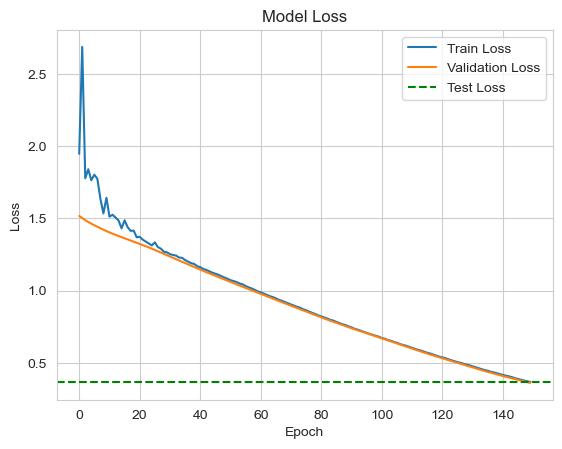

Fold 4 results: Test Loss(mse): 0.3650871813297272, Test MAE: 0.06670397520065308
Processing fold 5/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.2903 - mae: 1.0590 - val_loss: 1.6175 - val_mae: 0.0163 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 398ms/step - loss: 2.4008 - mae: 0.7251 - val_loss: 1.6117 - val_mae: 0.0159 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 389ms/step - loss: 2.2607 - mae: 0.6722 - val_loss: 1.6058 - val_mae: 0.0316 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 389ms/step - loss: 2.0460 - mae: 0.5310 - val_loss: 1.6014 - val_mae: 0.0561 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 390ms/step - loss: 1.8442 - mae: 0.4377 - val_loss: 1.5959 - val_mae: 0.0652 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 389ms/step - loss: 1.9158 - mae: 0.4652 - val_loss: 1.5878 - val_mae: 0.0539 - lr: 0.0010
Epoch 7/150
1/1 [=================

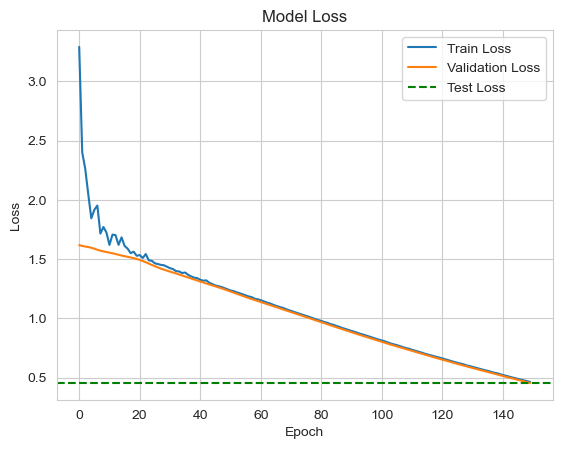

Fold 5 results: Test Loss(mse): 0.4552096724510193, Test MAE: 0.012522089295089245
Average Loss: 0.8310179829597473 ± 0.5466633711689605
Average MAE: 0.22429421450942755 ± 0.3164411686108572


In [10]:
model_109 = cv_gru(datawc109, datawc109["RUL"])

cv - mse: [0.39749857783317566, 1.2090325355529785, 1.728261947631836, 0.3650871813297272, 0.4552096724510193]
cv - mae: [0.055335961282253265, 0.852307915687561, 0.13460113108158112, 0.06670397520065308, 0.012522089295089245]


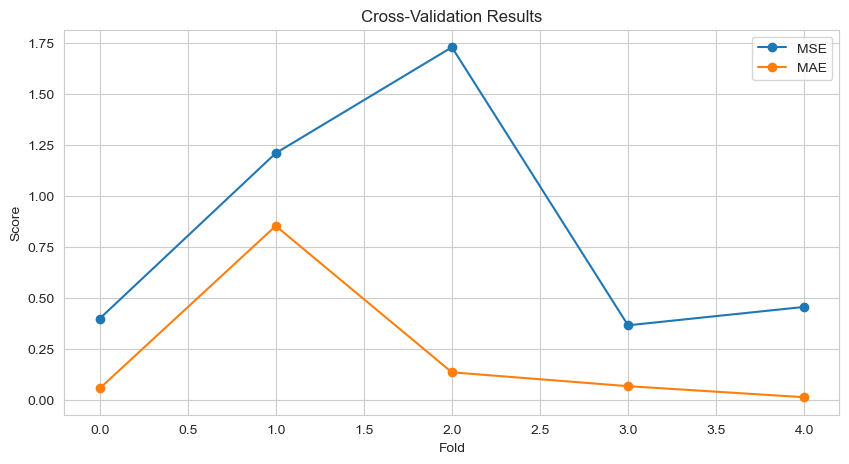

In [11]:
plot_cv_results(model_109)

In [12]:
tf.compat.v1.reset_default_graph()

MODAL FOR WORK CENTER 105

Processing fold 1/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.5517 - mae: 0.7495 - val_loss: 1.6457 - val_mae: 0.1053 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 397ms/step - loss: 2.7528 - mae: 0.8536 - val_loss: 1.6295 - val_mae: 0.0529 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 385ms/step - loss: 2.1293 - mae: 0.5810 - val_loss: 1.6191 - val_mae: 0.0067 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 388ms/step - loss: 2.0327 - mae: 0.5538 - val_loss: 1.6117 - val_mae: 0.0240 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 389ms/step - loss: 2.0089 - mae: 0.4912 - val_loss: 1.6056 - val_mae: 0.0495 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 395ms/step - loss: 1.9642 - mae: 0.4273 - val_loss: 1.5997 - val_mae: 0.0676 - lr: 0.0010
Epoch 7/150
1/1 [==============================] - 0s 391ms/step - loss: 1.7521 - mae: 0.3068 - val_loss: 1.5946 - v

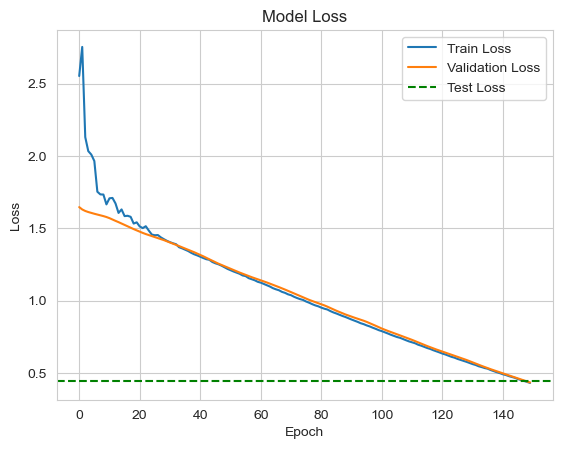

Fold 1 results: Test Loss(mse): 0.44656917452812195, Test MAE: 0.15430983901023865
Processing fold 2/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.1289 - mae: 0.8761 - val_loss: 1.7228 - val_mae: 0.0647 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 448ms/step - loss: 2.9193 - mae: 0.9139 - val_loss: 1.7155 - val_mae: 0.0674 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 389ms/step - loss: 2.4197 - mae: 0.7122 - val_loss: 1.7062 - val_mae: 0.0565 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 389ms/step - loss: 2.2718 - mae: 0.5923 - val_loss: 1.6980 - val_mae: 0.0536 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 381ms/step - loss: 2.4099 - mae: 0.6729 - val_loss: 1.6894 - val_mae: 0.0462 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 389ms/step - loss: 2.4150 - mae: 0.6323 - val_loss: 1.6798 - val_mae: 0.0151 - lr: 0.0010
Epoch 7/150
1/1 [================

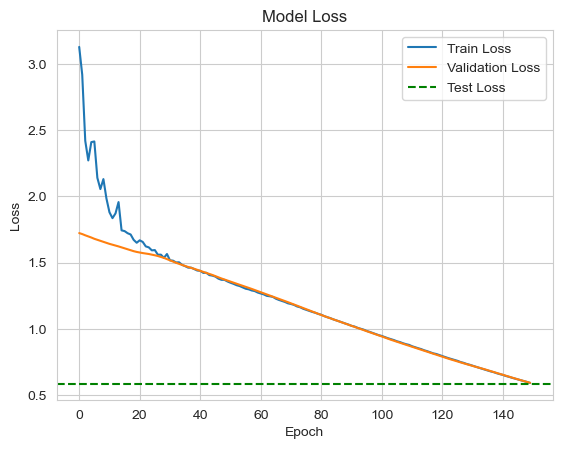

Fold 2 results: Test Loss(mse): 0.5853596925735474, Test MAE: 0.05858263373374939
Processing fold 3/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.4621 - mae: 0.8249 - val_loss: 1.5070 - val_mae: 0.2572 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 408ms/step - loss: 2.6513 - mae: 0.8205 - val_loss: 1.5065 - val_mae: 0.2687 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 395ms/step - loss: 2.0303 - mae: 0.6038 - val_loss: 1.4959 - val_mae: 0.2611 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 391ms/step - loss: 2.1749 - mae: 0.7033 - val_loss: 1.4834 - val_mae: 0.2501 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 389ms/step - loss: 1.9574 - mae: 0.5623 - val_loss: 1.4698 - val_mae: 0.2362 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 386ms/step - loss: 1.7816 - mae: 0.5247 - val_loss: 1.4587 - val_mae: 0.2277 - lr: 0.0010
Epoch 7/150
1/1 [=================

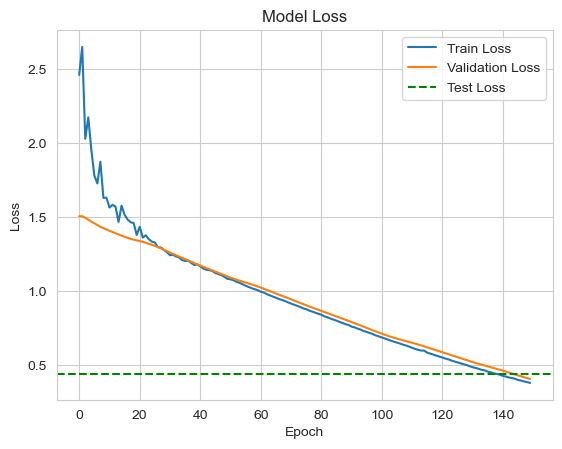

Fold 3 results: Test Loss(mse): 0.43801963329315186, Test MAE: 0.2610809803009033
Processing fold 4/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.9159 - mae: 0.8552 - val_loss: 1.7170 - val_mae: 0.0083 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 398ms/step - loss: 3.0094 - mae: 0.7863 - val_loss: 1.7106 - val_mae: 0.0326 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 389ms/step - loss: 2.5831 - mae: 0.7469 - val_loss: 1.7034 - val_mae: 0.0389 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 385ms/step - loss: 2.7413 - mae: 0.8091 - val_loss: 1.6992 - val_mae: 0.0660 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 382ms/step - loss: 2.4258 - mae: 0.6350 - val_loss: 1.6939 - val_mae: 0.0785 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 378ms/step - loss: 2.4496 - mae: 0.7169 - val_loss: 1.6877 - val_mae: 0.0836 - lr: 0.0010
Epoch 7/150
1/1 [=================

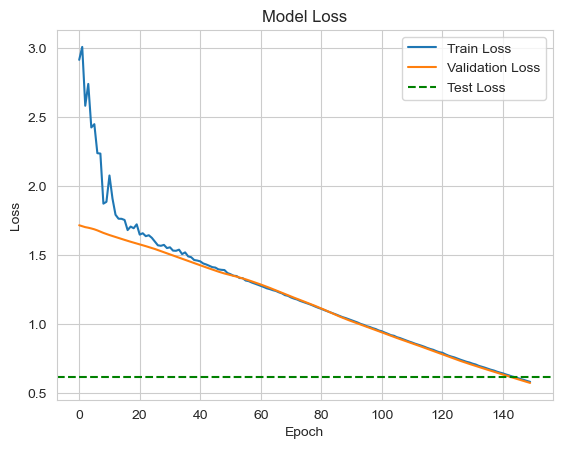

Fold 4 results: Test Loss(mse): 0.6181485652923584, Test MAE: 0.21116894483566284
Processing fold 5/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.0837 - mae: 1.0373 - val_loss: 1.6027 - val_mae: 0.1832 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 374ms/step - loss: 3.5387 - mae: 1.2041 - val_loss: 1.6028 - val_mae: 0.2008 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 376ms/step - loss: 2.7660 - mae: 0.8811 - val_loss: 1.6044 - val_mae: 0.2198 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 414ms/step - loss: 2.1357 - mae: 0.6241 - val_loss: 1.6108 - val_mae: 0.2476 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 375ms/step - loss: 2.1753 - mae: 0.6243 - val_loss: 1.6134 - val_mae: 0.2555 - lr: 2.0000e-04
Epoch 6/150
1/1 [==============================] - 0s 377ms/step - loss: 1.9573 - mae: 0.5533 - val_loss: 1.6156 - val_mae: 0.2623 - lr: 2.0000e-04
Epoch 7/150
1/1 [=========

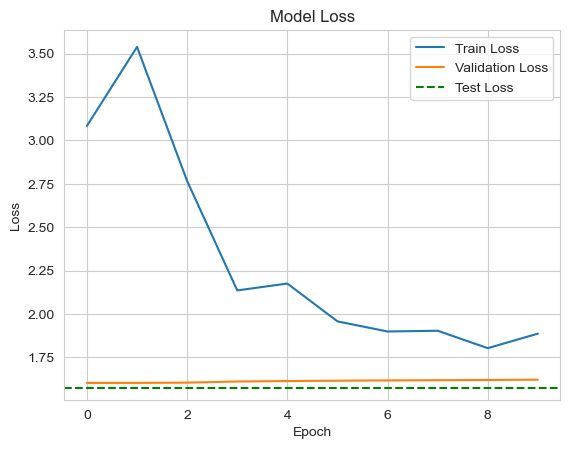

Fold 5 results: Test Loss(mse): 1.5706088542938232, Test MAE: 0.0378684476017952
Average Loss: 0.7317411839962006 ± 0.4255878796810697
Average MAE: 0.1446021690964699 ± 0.08588845756582877


In [13]:
model_105 = cv_gru(datawc105, datawc105["RUL"])

cv - mse: [0.44656917452812195, 0.5853596925735474, 0.43801963329315186, 0.6181485652923584, 1.5706088542938232]
cv - mae: [0.15430983901023865, 0.05858263373374939, 0.2610809803009033, 0.21116894483566284, 0.0378684476017952]


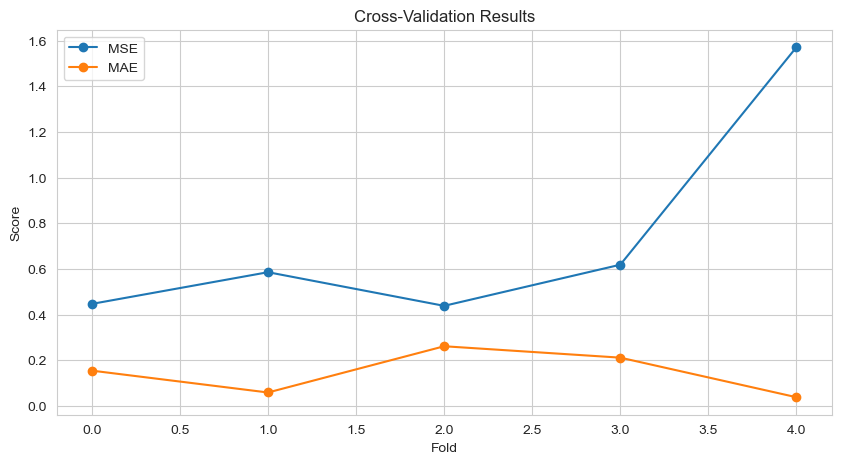

In [14]:
plot_cv_results(model_105)

In [15]:
tf.compat.v1.reset_default_graph()

MODAL FOR WORK CENTER 110

Processing fold 1/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.4047 - mae: 0.6932 - val_loss: 1.6638 - val_mae: 0.0514 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 394ms/step - loss: 2.5295 - mae: 0.7546 - val_loss: 1.6566 - val_mae: 0.0563 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 381ms/step - loss: 2.1049 - mae: 0.4974 - val_loss: 1.6521 - val_mae: 0.0798 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 383ms/step - loss: 2.4987 - mae: 0.6899 - val_loss: 1.6504 - val_mae: 0.1091 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 388ms/step - loss: 2.3423 - mae: 0.7110 - val_loss: 1.6414 - val_mae: 0.0997 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 388ms/step - loss: 1.9940 - mae: 0.4560 - val_loss: 1.6318 - val_mae: 0.0885 - lr: 0.0010
Epoch 7/150
1/1 [==============================] - 0s 390ms/step - loss: 1.8223 - mae: 0.3889 - val_loss: 1.6226 - v

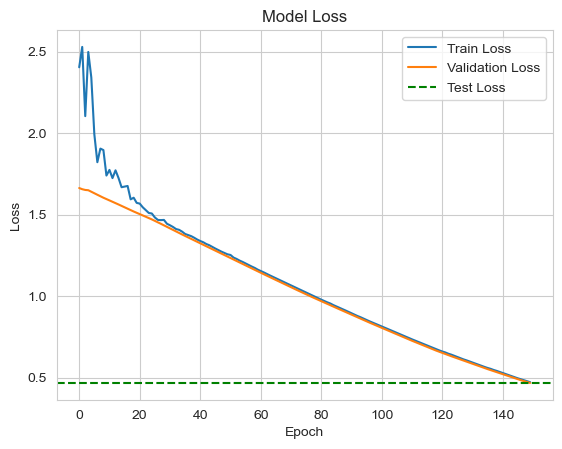

Fold 1 results: Test Loss(mse): 0.4681471288204193, Test MAE: 0.050749972462654114
Processing fold 2/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.9707 - mae: 1.0358 - val_loss: 1.8406 - val_mae: 0.5049 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 390ms/step - loss: 1.9387 - mae: 0.4626 - val_loss: 1.7824 - val_mae: 0.4523 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 389ms/step - loss: 2.1274 - mae: 0.5242 - val_loss: 1.7468 - val_mae: 0.4205 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 389ms/step - loss: 2.1535 - mae: 0.6227 - val_loss: 1.7192 - val_mae: 0.3961 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 386ms/step - loss: 1.8027 - mae: 0.3999 - val_loss: 1.7073 - val_mae: 0.3909 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 387ms/step - loss: 1.7688 - mae: 0.3748 - val_loss: 1.6920 - val_mae: 0.3817 - lr: 0.0010
Epoch 7/150
1/1 [================

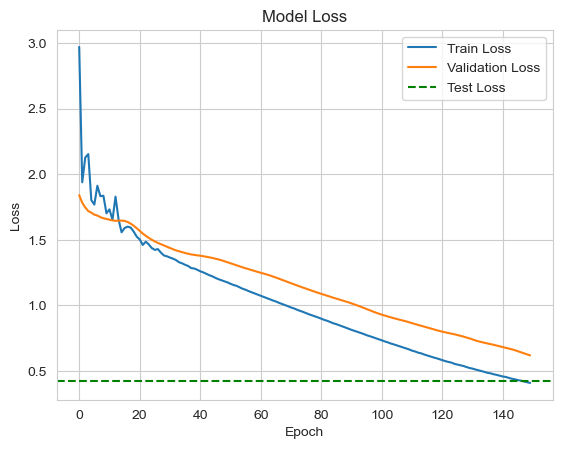

Fold 2 results: Test Loss(mse): 0.421075701713562, Test MAE: 0.144505575299263
Processing fold 3/5...
Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 2.7071 - mae: 0.8707 - val_loss: 2.9770 - val_mae: 1.1819 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 392ms/step - loss: 2.5531 - mae: 0.8404 - val_loss: 2.9139 - val_mae: 1.1589 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 382ms/step - loss: 2.0701 - mae: 0.5481 - val_loss: 2.8035 - val_mae: 1.1144 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 383ms/step - loss: 2.3928 - mae: 0.7039 - val_loss: 2.6690 - val_mae: 1.0565 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 387ms/step - loss: 2.1537 - mae: 0.5124 - val_loss: 2.5966 - val_mae: 1.0260 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 387ms/step - loss: 1.9242 - mae: 0.4771 - val_loss: 2.5493 - val_mae: 1.0070 - lr: 0.0010
Epoch 7/150
1/1 [====================

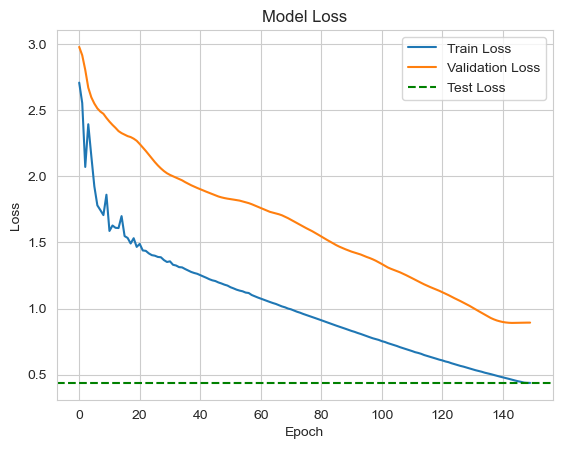

Fold 3 results: Test Loss(mse): 0.4364917278289795, Test MAE: 0.044515080749988556
Processing fold 4/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.1779 - mae: 1.0667 - val_loss: 1.4296 - val_mae: 0.0200 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 389ms/step - loss: 2.9852 - mae: 1.0558 - val_loss: 1.4233 - val_mae: 0.0384 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 403ms/step - loss: 2.0041 - mae: 0.5918 - val_loss: 1.4178 - val_mae: 0.0577 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 441ms/step - loss: 1.8654 - mae: 0.5622 - val_loss: 1.4117 - val_mae: 0.0672 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 410ms/step - loss: 1.9833 - mae: 0.6252 - val_loss: 1.4048 - val_mae: 0.0680 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 397ms/step - loss: 1.9547 - mae: 0.6304 - val_loss: 1.3969 - val_mae: 0.0621 - lr: 0.0010
Epoch 7/150
1/1 [================

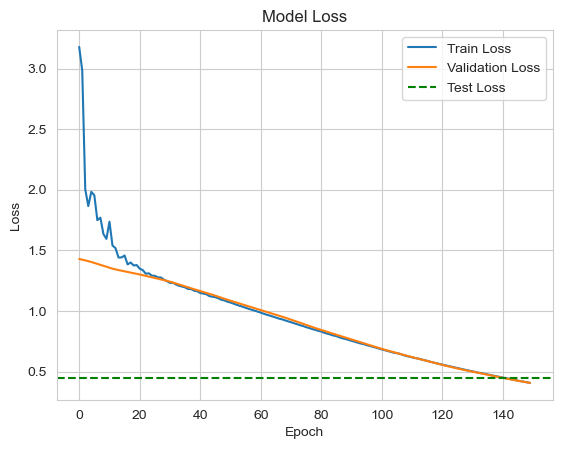

Fold 4 results: Test Loss(mse): 0.4453776478767395, Test MAE: 0.21100623905658722
Processing fold 5/5...
Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 3.1293 - mae: 1.0125 - val_loss: 1.5147 - val_mae: 0.2372 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 406ms/step - loss: 4.0094 - mae: 1.2387 - val_loss: 1.4971 - val_mae: 0.2137 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 399ms/step - loss: 2.9232 - mae: 0.9813 - val_loss: 1.4879 - val_mae: 0.2086 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 396ms/step - loss: 2.4769 - mae: 0.8307 - val_loss: 1.4853 - val_mae: 0.2196 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 395ms/step - loss: 2.9242 - mae: 0.9950 - val_loss: 1.4828 - val_mae: 0.2312 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 401ms/step - loss: 2.0883 - mae: 0.6822 - val_loss: 1.4828 - val_mae: 0.2471 - lr: 0.0010
Epoch 7/150
1/1 [=================

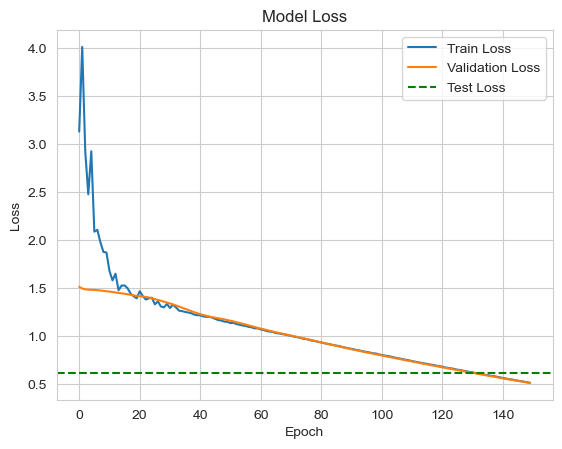

Fold 5 results: Test Loss(mse): 0.6152594685554504, Test MAE: 0.3269612193107605
Average Loss: 0.47727033495903015 ± 0.07065707179798342
Average MAE: 0.15554761737585068 ± 0.10572698700821258


In [16]:
model_110 = cv_gru(datawc110, datawc110["RUL"])

cv - mse: [0.4681471288204193, 0.421075701713562, 0.4364917278289795, 0.4453776478767395, 0.6152594685554504]
cv - mae: [0.050749972462654114, 0.144505575299263, 0.044515080749988556, 0.21100623905658722, 0.3269612193107605]


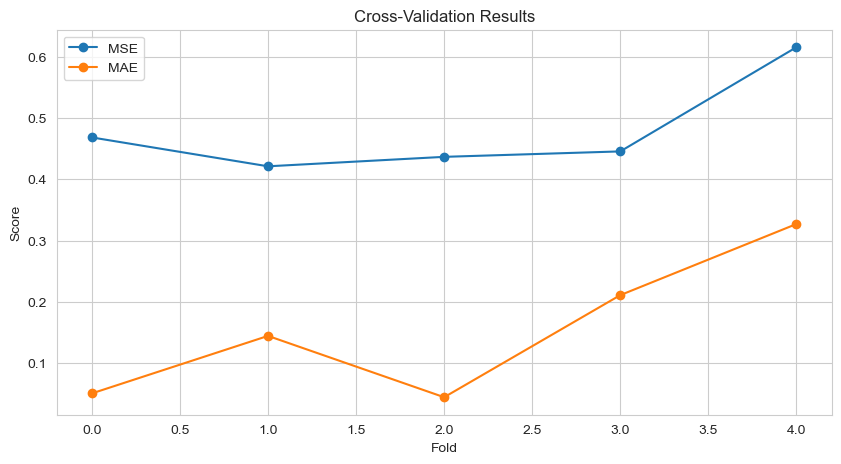

In [17]:
plot_cv_results(model_110)

In [18]:
tf.compat.v1.reset_default_graph()

MODAL FOR WORK CENTER 111

Processing fold 1/5...
Epoch 1/150
1/1 [==============================] - 10s 10s/step - loss: 2.5552 - mae: 0.8159 - val_loss: 1.5937 - val_mae: 0.2003 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 387ms/step - loss: 2.3874 - mae: 0.7820 - val_loss: 1.5966 - val_mae: 0.2248 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 405ms/step - loss: 2.1392 - mae: 0.6416 - val_loss: 1.5725 - val_mae: 0.1835 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 410ms/step - loss: 2.1216 - mae: 0.6594 - val_loss: 1.5474 - val_mae: 0.1255 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 412ms/step - loss: 2.0434 - mae: 0.5995 - val_loss: 1.5326 - val_mae: 0.0895 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 385ms/step - loss: 2.0215 - mae: 0.5726 - val_loss: 1.5215 - val_mae: 0.0655 - lr: 0.0010
Epoch 7/150
1/1 [==============================] - 0s 417ms/step - loss: 2.0199 - mae: 0.5793 - val_loss: 1.5124 -

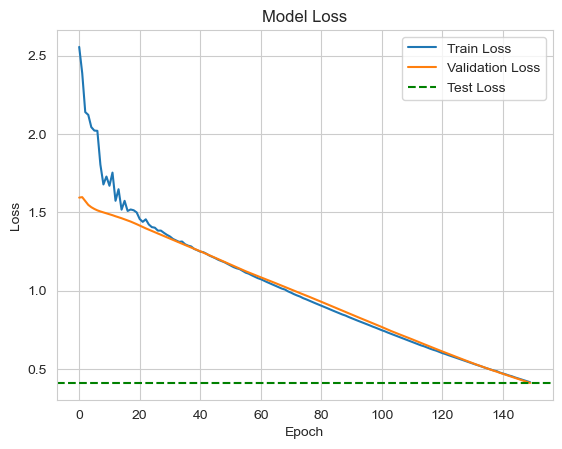

Fold 1 results: Test Loss(mse): 0.4098413586616516, Test MAE: 0.039759330451488495
Processing fold 2/5...
Epoch 1/150
1/1 [==============================] - 9s 9s/step - loss: 3.0743 - mae: 1.0064 - val_loss: 1.6981 - val_mae: 0.0945 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 383ms/step - loss: 3.1145 - mae: 1.0308 - val_loss: 1.7071 - val_mae: 0.1648 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 380ms/step - loss: 2.1529 - mae: 0.5531 - val_loss: 1.7128 - val_mae: 0.2033 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 369ms/step - loss: 2.1272 - mae: 0.5686 - val_loss: 1.7171 - val_mae: 0.2327 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 384ms/step - loss: 1.8487 - mae: 0.3293 - val_loss: 1.7215 - val_mae: 0.2452 - lr: 2.0000e-04
Epoch 6/150
1/1 [==============================] - 0s 377ms/step - loss: 2.1545 - mae: 0.5214 - val_loss: 1.7244 - val_mae: 0.2545 - lr: 2.0000e-04
Epoch 7/150
1/1 [========

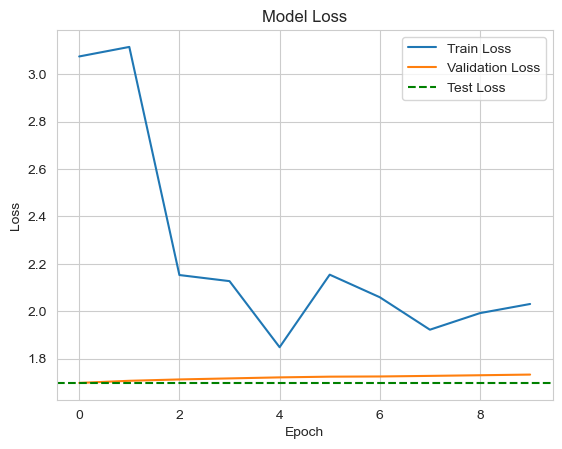

Fold 2 results: Test Loss(mse): 1.6977229118347168, Test MAE: 0.09253782033920288
Processing fold 3/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.0401 - mae: 0.7047 - val_loss: 1.4667 - val_mae: 0.2873 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 382ms/step - loss: 2.5618 - mae: 0.8843 - val_loss: 1.4266 - val_mae: 0.2235 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 383ms/step - loss: 2.5961 - mae: 0.8315 - val_loss: 1.3980 - val_mae: 0.1690 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 388ms/step - loss: 1.9144 - mae: 0.5904 - val_loss: 1.3807 - val_mae: 0.1356 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 388ms/step - loss: 2.0035 - mae: 0.6751 - val_loss: 1.3704 - val_mae: 0.1238 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 393ms/step - loss: 1.9394 - mae: 0.5852 - val_loss: 1.3623 - val_mae: 0.1203 - lr: 0.0010
Epoch 7/150
1/1 [=================

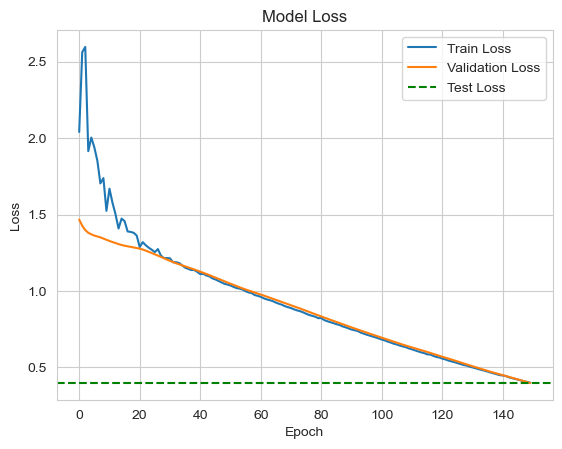

Fold 3 results: Test Loss(mse): 0.40071922540664673, Test MAE: 0.0948128029704094
Processing fold 4/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.8314 - mae: 0.8704 - val_loss: 1.5774 - val_mae: 0.2188 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 396ms/step - loss: 2.5149 - mae: 0.8186 - val_loss: 1.5586 - val_mae: 0.1926 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 390ms/step - loss: 2.2262 - mae: 0.6739 - val_loss: 1.5569 - val_mae: 0.2081 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 397ms/step - loss: 1.9879 - mae: 0.5294 - val_loss: 1.5495 - val_mae: 0.2090 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 382ms/step - loss: 2.1006 - mae: 0.6058 - val_loss: 1.5409 - val_mae: 0.2066 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 383ms/step - loss: 1.9282 - mae: 0.5552 - val_loss: 1.5310 - val_mae: 0.2007 - lr: 0.0010
Epoch 7/150
1/1 [=================

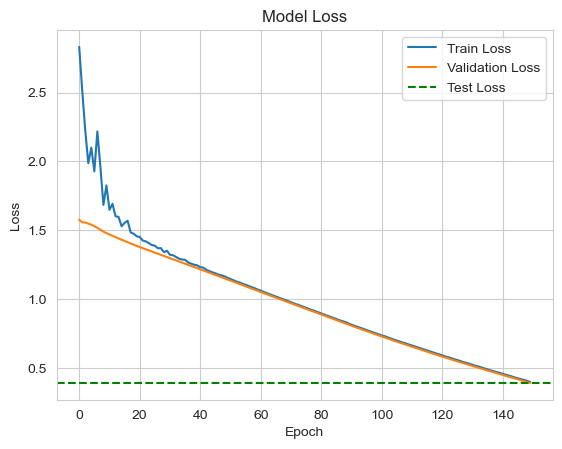

Fold 4 results: Test Loss(mse): 0.39299342036247253, Test MAE: 0.009762926027178764
Processing fold 5/5...
Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 3.1376 - mae: 0.9958 - val_loss: 1.6007 - val_mae: 0.1111 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 395ms/step - loss: 2.4719 - mae: 0.7509 - val_loss: 1.5886 - val_mae: 0.0858 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 386ms/step - loss: 2.6528 - mae: 0.7324 - val_loss: 1.5767 - val_mae: 0.0471 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 390ms/step - loss: 2.2857 - mae: 0.6511 - val_loss: 1.5682 - val_mae: 0.0289 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 392ms/step - loss: 2.2590 - mae: 0.6683 - val_loss: 1.5610 - val_mae: 0.0314 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 394ms/step - loss: 2.0439 - mae: 0.6095 - val_loss: 1.5545 - val_mae: 0.0398 - lr: 0.0010
Epoch 7/150
1/1 [===============

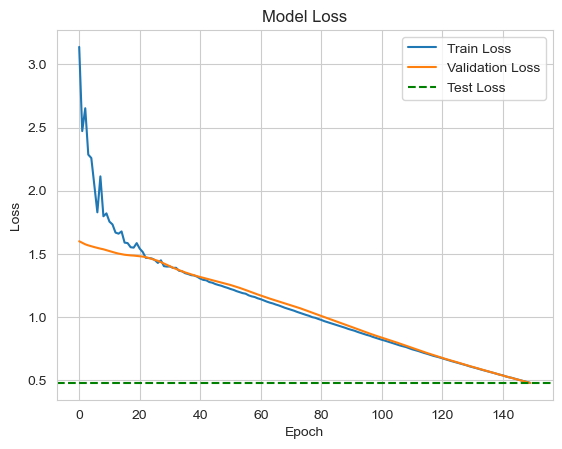

Fold 5 results: Test Loss(mse): 0.47631004452705383, Test MAE: 0.057856157422065735
Average Loss: 0.6755173921585083 ± 0.5119580595461078
Average MAE: 0.05894580744206905 ± 0.032258731405492444


In [19]:
model_111 = cv_gru(datawc111, datawc111["RUL"])

cv - mse: [0.4098413586616516, 1.6977229118347168, 0.40071922540664673, 0.39299342036247253, 0.47631004452705383]
cv - mae: [0.039759330451488495, 0.09253782033920288, 0.0948128029704094, 0.009762926027178764, 0.057856157422065735]


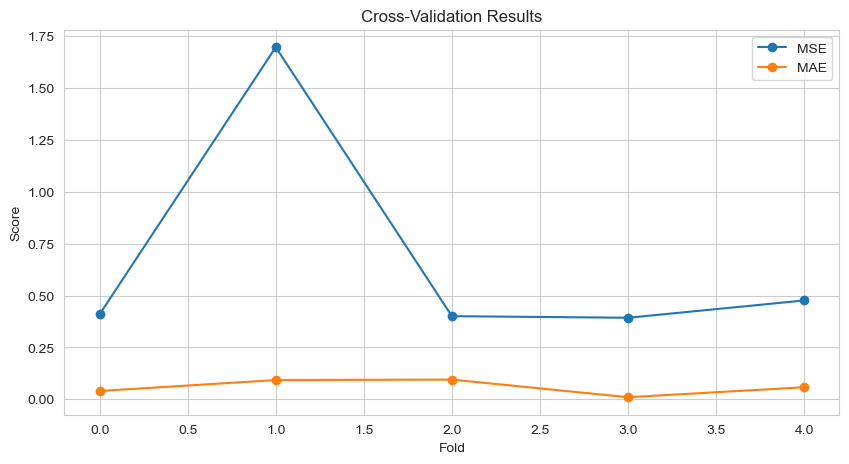

In [20]:
plot_cv_results(model_111)

In [21]:
tf.compat.v1.reset_default_graph()

MODAL FOR WORK CENTER 112

Processing fold 1/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.5240 - mae: 0.7466 - val_loss: 1.5830 - val_mae: 0.0027 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 405ms/step - loss: 2.2029 - mae: 0.6008 - val_loss: 1.5749 - val_mae: 0.0067 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 383ms/step - loss: 1.9979 - mae: 0.5244 - val_loss: 1.5675 - val_mae: 0.0275 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 379ms/step - loss: 1.8080 - mae: 0.3777 - val_loss: 1.5593 - val_mae: 0.0379 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 387ms/step - loss: 1.9340 - mae: 0.4782 - val_loss: 1.5517 - val_mae: 0.0477 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 392ms/step - loss: 1.9019 - mae: 0.4267 - val_loss: 1.5452 - val_mae: 0.0620 - lr: 0.0010
Epoch 7/150
1/1 [==============================] - 0s 377ms/step - loss: 1.8390 - mae: 0.4295 - val_loss: 1.5391 - v

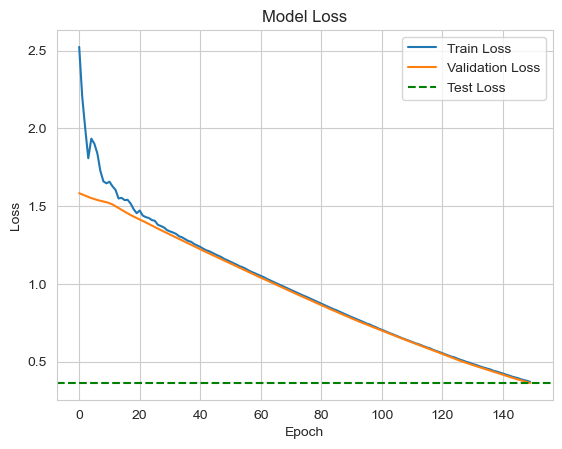

Fold 1 results: Test Loss(mse): 0.3621043860912323, Test MAE: 0.015086570754647255
Processing fold 2/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.1877 - mae: 0.6368 - val_loss: 1.5199 - val_mae: 0.1701 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 399ms/step - loss: 2.3576 - mae: 0.7350 - val_loss: 1.5028 - val_mae: 0.1414 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 394ms/step - loss: 2.0375 - mae: 0.5907 - val_loss: 1.4961 - val_mae: 0.1467 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 386ms/step - loss: 2.0762 - mae: 0.6245 - val_loss: 1.4872 - val_mae: 0.1435 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 387ms/step - loss: 1.8953 - mae: 0.5342 - val_loss: 1.4773 - val_mae: 0.1362 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 378ms/step - loss: 1.8140 - mae: 0.4313 - val_loss: 1.4714 - val_mae: 0.1438 - lr: 0.0010
Epoch 7/150
1/1 [================

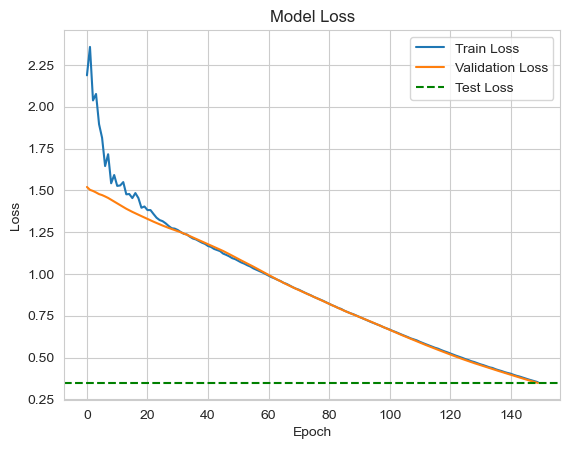

Fold 2 results: Test Loss(mse): 0.34731510281562805, Test MAE: 0.044641174376010895
Processing fold 3/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 2.4533 - mae: 0.7344 - val_loss: 1.6002 - val_mae: 0.1109 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 393ms/step - loss: 2.5590 - mae: 0.7798 - val_loss: 1.5889 - val_mae: 0.0831 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 383ms/step - loss: 2.2747 - mae: 0.6239 - val_loss: 1.5785 - val_mae: 0.0616 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 392ms/step - loss: 2.0052 - mae: 0.5686 - val_loss: 1.5696 - val_mae: 0.0525 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 391ms/step - loss: 1.9474 - mae: 0.5215 - val_loss: 1.5612 - val_mae: 0.0487 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 387ms/step - loss: 1.9460 - mae: 0.4512 - val_loss: 1.5538 - val_mae: 0.0517 - lr: 0.0010
Epoch 7/150
1/1 [===============

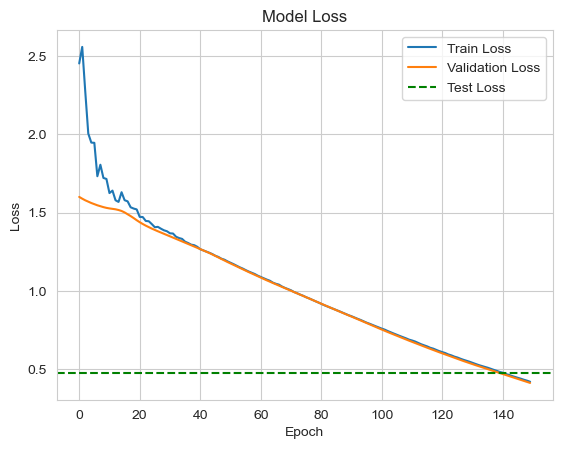

Fold 3 results: Test Loss(mse): 0.4771853983402252, Test MAE: 0.25805121660232544
Processing fold 4/5...
Epoch 1/150
1/1 [==============================] - 7s 7s/step - loss: 3.3169 - mae: 0.9639 - val_loss: 1.6997 - val_mae: 0.1849 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 392ms/step - loss: 2.8161 - mae: 0.8705 - val_loss: 1.6771 - val_mae: 0.1370 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 396ms/step - loss: 2.4316 - mae: 0.7412 - val_loss: 1.6633 - val_mae: 0.1121 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 387ms/step - loss: 2.4665 - mae: 0.7265 - val_loss: 1.6529 - val_mae: 0.0993 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 381ms/step - loss: 2.1812 - mae: 0.6038 - val_loss: 1.6423 - val_mae: 0.0843 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 387ms/step - loss: 2.3021 - mae: 0.6556 - val_loss: 1.6318 - val_mae: 0.0661 - lr: 0.0010
Epoch 7/150
1/1 [=================

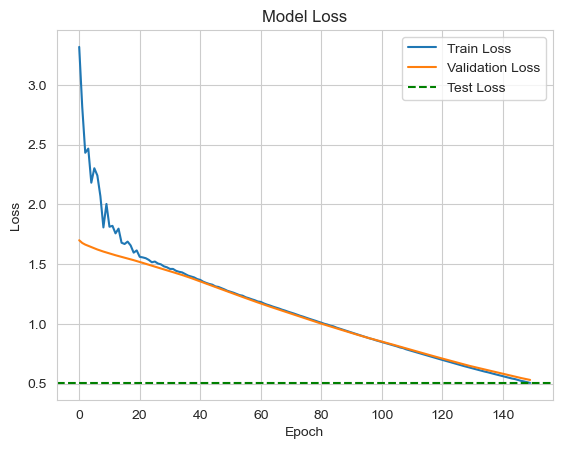

Fold 4 results: Test Loss(mse): 0.5031964182853699, Test MAE: 0.07083206623792648
Processing fold 5/5...
Epoch 1/150
1/1 [==============================] - 8s 8s/step - loss: 3.3974 - mae: 1.0784 - val_loss: 1.6920 - val_mae: 0.2718 - lr: 0.0010
Epoch 2/150
1/1 [==============================] - 0s 397ms/step - loss: 2.9784 - mae: 0.9210 - val_loss: 1.6657 - val_mae: 0.2336 - lr: 0.0010
Epoch 3/150
1/1 [==============================] - 0s 394ms/step - loss: 2.3664 - mae: 0.6842 - val_loss: 1.6545 - val_mae: 0.2245 - lr: 0.0010
Epoch 4/150
1/1 [==============================] - 0s 395ms/step - loss: 2.1488 - mae: 0.5798 - val_loss: 1.6358 - val_mae: 0.1970 - lr: 0.0010
Epoch 5/150
1/1 [==============================] - 0s 385ms/step - loss: 2.1379 - mae: 0.6304 - val_loss: 1.6228 - val_mae: 0.1818 - lr: 0.0010
Epoch 6/150
1/1 [==============================] - 0s 397ms/step - loss: 2.2299 - mae: 0.6262 - val_loss: 1.6118 - val_mae: 0.1705 - lr: 0.0010
Epoch 7/150
1/1 [=================

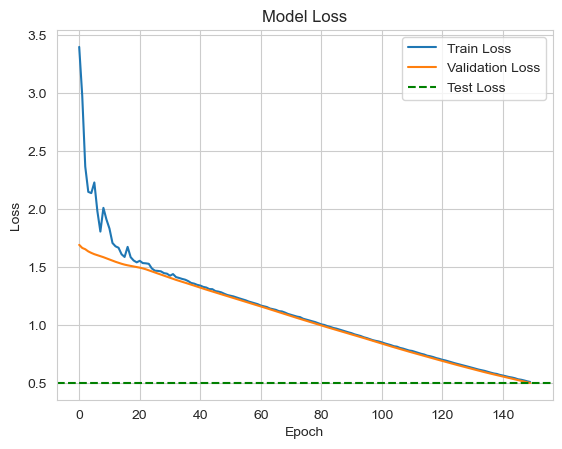

Fold 5 results: Test Loss(mse): 0.5021885633468628, Test MAE: 0.004761275835335255
Average Loss: 0.43839797377586365 ± 0.06912212805918916
Average MAE: 0.07867446076124907 ± 0.0926308446809077


In [22]:
model_112 = cv_gru(datawc112, datawc112["RUL"])

cv - mse: [0.3621043860912323, 0.34731510281562805, 0.4771853983402252, 0.5031964182853699, 0.5021885633468628]
cv - mae: [0.015086570754647255, 0.044641174376010895, 0.25805121660232544, 0.07083206623792648, 0.004761275835335255]


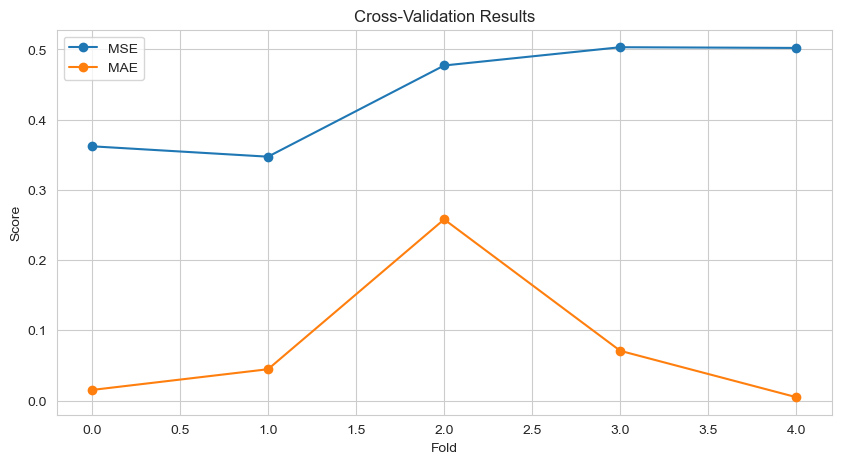

In [23]:
plot_cv_results(model_112)

In [24]:
tf.compat.v1.reset_default_graph()

FINAL COMPARISON 

In [25]:
final_result = {
    "Model Name":["model_109", "model_105", "model_110", "model_111", "model_112"],
    "Mean Loss": [],
    "Std Loss": [],
    "Mean MAE": [],
    "Std MAE": []
}

models  = [model_109, model_105, model_110, model_111, model_112]
for model in models:
    losses = [result['loss'] for result in model]
    maes = [result['mae'] for result in model]

    final_result["Mean Loss"].append(np.mean(losses))
    final_result["Std Loss"].append(np.std(losses))
    final_result["Mean MAE"].append(np.mean(maes))
    final_result["Std MAE"].append(np.std(maes))
      

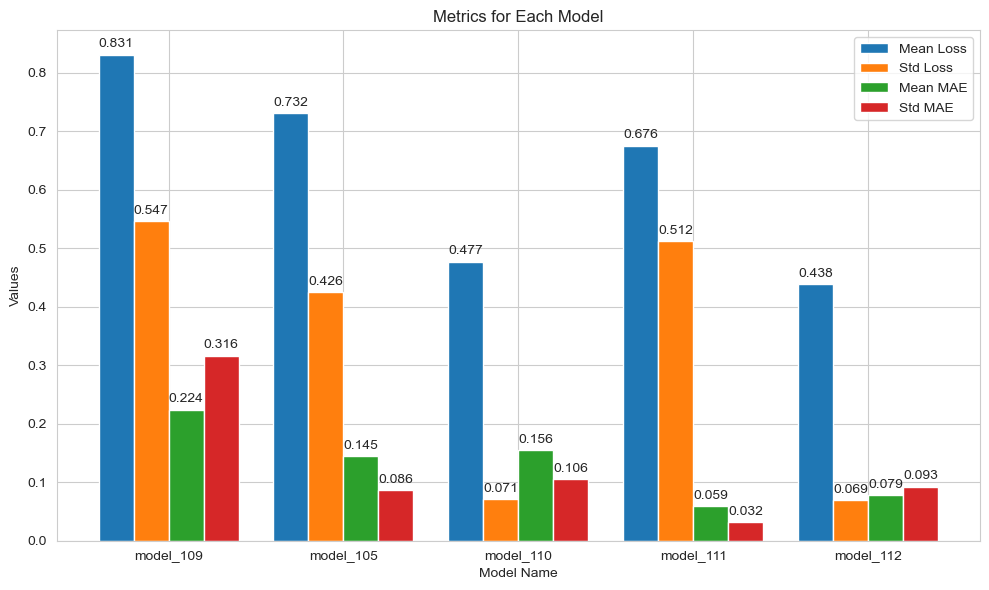

In [26]:
model_names = final_result["Model Name"]
mean_loss = final_result["Mean Loss"]
std_loss = final_result["Std Loss"]
mean_mae = final_result["Mean MAE"]
std_mae = final_result["Std MAE"]

x = np.arange(len(model_names))  
width = 0.2  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - 1.5*width, mean_loss, width, label='Mean Loss')
bars2 = ax.bar(x - 0.5*width, std_loss, width, label='Std Loss')
bars3 = ax.bar(x + 0.5*width, mean_mae, width, label='Mean MAE')
bars4 = ax.bar(x + 1.5*width, std_mae, width, label='Std MAE')

ax.set_xlabel('Model Name')
ax.set_ylabel('Values')
ax.set_title('Metrics for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.show()